## Morning practical 2 day 2

Welcome to the second practical of today. Here, you will work on implementing regularised logistic regression, as well as implementing cross-validation on some data and making an ROC curve. First run the two cells below to set things up.



In [ ]:
# run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import seaborn as sns
from IPython.display import display, Markdown
from scipy.optimize import fmin_bfgs
from scipy.special import expit

In [ ]:
# important functions
def mySigmoid(data):
    output = 1 / (1 + np.exp(-data))
    return output


# I have redefined the mySigmoid for numerical stability here.
# Why this? Well, with many parameters and large values, numerical precision for the power function becomes
# an issue. Read here: https://github.com/scipy/scipy/blob/91a279ecb05e7814e2787bfa618d46ad3e0af2be/scipy/special/_logit.h
# how scipy fixes that.
def mySigmoid(data):
    data = np.array(data)
    return expit(data)


def linAlgRegHypothesis(data, thetas):
    data = np.array(data)
    oneFeatToAdd = np.ones(len(data))
    newFeatArray = np.c_[oneFeatToAdd, data]
    # make sure thetas are always of the form np.array([[theta1], [theta2]]), i.e. column vector
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    predictions = newFeatArray @ thetas
    return predictions


def linAlgLogRegHypothesis(data, thetas):
    output = mySigmoid(linAlgRegHypothesis(data, thetas))
    return output


def costFuncLogReg(x, y, thetas):
    predictions = linAlgLogRegHypothesis(x, thetas)
    costsPerSample = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    totalCosts = np.nansum(1 / len(x) * costsPerSample)
    return totalCosts


def makeCrossValData(featureArray, y, k=10):
    """function to make splits into training and validation sets.
    Outputs two lists of length k, where each element is the indices of samples to train on for that fold,
    and the indices of samples to test on for that fold, respectively."""
    m = len(featureArray)
    # shuffle data
    shuffled_indices = np.random.permutation(m)
    shuffled_features = featureArray[shuffled_indices, :]  # assumes 2D array
    shuffled_labels = y[shuffled_indices]
    # see how many equal-sized sets you can make
    dataPerSplit = int(np.floor(m / k))
    dataPartitions = []
    counter = 0

    for i in range(0, k):
        # make a list of all the samples for each fold
        dataPartitions.append(list(range(counter, counter + dataPerSplit)))
        counter += dataPerSplit

    samplesEquallySplit = k * dataPerSplit
    if not samplesEquallySplit == m:
        # after making equal splits there will be samples left, i.e. you cannot always make k exactly evenly sized subsets.
        # randomly assign left over samples to folds after
        toDivide = m - samplesEquallySplit
        for extraSampleIndex in range(counter, counter + toDivide):
            # only assign to lists of samples that have the current minimum amount of samples
            currentSubsetSizes = np.array([len(subset) for subset in dataPartitions])
            assignTo = np.random.choice(
                np.where(currentSubsetSizes == np.min(currentSubsetSizes))[0]
            )
            dataPartitions[assignTo].append(extraSampleIndex)

    # Now make the final cross-validation set: make k sets, each set has (k-1)/k folds to train on, and 1 fold to test on.
    testSet = []
    trainSet = []
    for validationSetIndex in range(0, k):
        # put 1 fold in the test set
        testSet.append(dataPartitions[validationSetIndex])
        # put all other folds in the train set
        trainSet.append(dataPartitions.copy())
        trainSet[validationSetIndex].pop(validationSetIndex)
        # this line makes sure all training set indices are in one big list, rather than k-1 small lists.
        trainSet[validationSetIndex] = [
            item for sublist in trainSet[validationSetIndex] for item in sublist
        ]

    return shuffled_features, shuffled_labels, trainSet, testSet

## Regularisation

Regularisation is a method of automatically constraining how much your model can (over)fit on the training data. We add some factor (regularisation weight $\lambda$) times the sum of squares of the parameter (excluding the intercept ($\theta_0$) to the cost function. In this way, the model cannot pick extremely large values for the parameters, i.e. when you have 100 features, the model is forced to only have high $\theta$ parameters for those features that matter a lot for correct classification, while having extremely low or even 0 values for features that don't. Hence, regularisation also automatically selects features that are of importance to your problem: _feature selection_! (Strictly speaking, this holds only for when you penalise the absolute of the sum of the parameters, not when you penalise the square). Note that once you have trained the model and want to know the cost on the validation/test set, you should not use regularised cost: you care about your performance in the end (which you hope is better because you constrain the parameters during fitting).

* To get started, change your costFuncLogReg to have an extra argument `lambda_ = 0` ( _ because lambda is a keword for anonymous functions), that, if set to a value higher than 0, causes regularisation to be performed.
* Make sure to exclude the bias/intercept term ($\theta_0$) from this. By convention this is not regularised.
* While you are at it, also reorder the arguments to `thetas, x, y, lambda_=0` so it is easier to use another optimizer if we want to!

Hint:
* Remember that the regularised logistic regression cost function is:
![APicture](RegLogRegEq.PNG) <div>
You already had the first part implemented, you only need to add the second part!



In [ ]:
# answer
def costFuncLogReg(thetas, x, y, lambda_=0):
    m = len(x)
    predictions = linAlgLogRegHypothesis(x, thetas)
    costsPerSample = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    # set the bias to 0 so you don't count it in regularisation.
    # It is convention not to regularise the bias/intercept
    thetas[0] = 0
    regCost = lambda_ / 2 * 1 / m * thetas.T @ thetas
    totalCosts = np.nansum(1 / m * costsPerSample) + regCost
    return totalCosts

## Changing gradient descent

The gradients should also change. Luckily, since all that's added is a plus term, the change is extremely minor:
![gradients_logreg](GradientsRegLogReg.PNG)

* Up to you to implement the changes in the `linAlgGradientDescent` function. Add another `lambda_ = 0` argument and change the gradients as needed. So `linAlgGradientDescent(x, y, thetas, alpha, lambda_ = 0, method = "linear")`.

In [ ]:
# old function
def linAlgGradientDescent(x, y, thetas, alpha, method="linear"):
    possible_methods = ["linear", "logistic"]
    if method not in possible_methods:
        print(
            "Error! Wrong method given. Should be one of: "
            + str(possible_methods)
            + "\n Returning None!"
        )
        return
    m = len(x)
    ## all these shape/ndim calls are unnecessary if you input column vectors as you should.
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    if method == "linear":
        preds = linAlgRegHypothesis(x, thetas)
    else:
        preds = linAlgLogRegHypothesis(x, thetas)

    if preds.shape != (m, 1):
        preds = preds[:, np.newaxis]
    if y.shape != (m, 1):
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation = errors.T @ np.c_[np.ones(len(errors)), x]
    finalGradientSteps = alpha / m * gradientSummation
    newThetas = thetas - finalGradientSteps.T
    return newThetas


# answer
def linAlgGradientDescent(x, y, thetas, alpha, lambda_=0, method="linear"):
    possible_methods = ["linear", "logistic"]
    if method not in possible_methods:
        print(
            "Error! Wrong method given. Should be one of: "
            + str(possible_methods)
            + "\n Returning None!"
        )
        return
    m = len(x)
    ## all these shape/ndim calls are unnecessary if you input column vectors as you should.
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    if method == "linear":
        preds = linAlgRegHypothesis(x, thetas)
    else:
        preds = linAlgLogRegHypothesis(x, thetas)

    if preds.shape != (m, 1):
        preds = preds[:, np.newaxis]
    if y.shape != (m, 1):
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation = errors.T @ np.c_[np.ones(len(errors)), x]
    gradientSummation[1:] += lambda_ / m * thetas[1:]
    finalGradientSteps = alpha / m * gradientSummation
    newThetas = thetas - finalGradientSteps.T
    return newThetas


# Refactoring into two separate functions

Below, I have made one function called `computeGradients()` that computes and returns the gradients, and another function called `gradientDescentStep()` that takes a step using current thetas, those gradients, and an alpha value. In this way, we can use the first one if we want to use some other optimizer (which wants just the gradients), and the second one if we want to use gradient descent proper.

In [ ]:
# refactor into separate functions
def computeGradients(thetas, x, y, lambda_=0, method="linear"):
    m = len(x)
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    if method == "linear":
        preds = linAlgRegHypothesis(x, thetas)
    else:
        preds = linAlgLogRegHypothesis(x, thetas)

    if preds.shape != (m, 1):
        preds = preds[:, np.newaxis]
    if y.ndim < 2:
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation = errors.T @ np.c_[np.ones(len(errors)), x]
    unregularisedGradients = 1 / m * gradientSummation
    regularisedGradients = np.ravel(unregularisedGradients)
    regularisedGradients[1:] = (
        regularisedGradients[1:] + lambda_ / m * np.ravel(thetas)[1:]
    )
    # print("final regularised gradients:")
    # print(regularisedGradients)
    return regularisedGradients


def gradientDescentStep(thetas, gradients, alpha):
    if thetas.ndim < 2:
        thetas = thetas[:, np.newaxis]
    if gradients.ndim < 2:
        gradients = gradients[:, np.newaxis]
    newThetas = thetas - alpha * gradients
    return newThetas

## Loading in some data 

Let's look at the Pima Indians dataset, which contains information on multiple clinical variables and whether or not patients have diabetes. The below code loads in the data. I am using pandas since it has a nice .describe() method for DataFrame that shows you information about the data. Up to you to investigate this data somewhat:

* Are there any NaNs in the data?
* Are there other values that seem circumspect? Name 2 examples. How many of these circumspect values are there in these features?
* How many cases and controls are there? Is this a balanced dataset?

Hint(s):
* Use the `.describe` method of the dataframe to help you answer these questions.
* You can slice a dataframe using `df.loc[df["colName"] < 12, :]`, which corresponds to getting you only rows for which the values in column _colName_ are less than 12.

In [ ]:
diabetesData = pd.read_csv("PimaIndiansDiabetes.csv")

# answer
display(diabetesData.describe())
# there are no NaNs
print("nr of NaNs:")
np.sum(np.isnan(diabetesData))
# there are indeed circumspect values. A SkinThickness of 0 or glucose level of 0 or
# even a BMI of 0 is probably not correct.
# we'll need to do something about this.
print("No. cases BMI not measured:")
print(len(diabetesData.loc[diabetesData["BMI"] <= 0, :]))
print("No. cases SkinThickness not measured:")
print(len(diabetesData.loc[diabetesData["SkinThickness"] <= 0, :]))
print("No. cases Insulin not measured:")
print(len(diabetesData.loc[diabetesData["Insulin"] <= 0, :]))
# etc.

# cases and controls
print("Nr. of cases: ")
print(len(diabetesData.loc[diabetesData["Outcome"] == 1, :]))
print("Nr. of controls: ")
print(len(diabetesData.loc[diabetesData["Outcome"] == 0, :]))
print("The dataset is unbalanced")


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


nr of NaNs:
No. cases BMI not measured:
11
No. cases SkinThickness not measured:
227
No. cases Insulin not measured:
374
Nr. of cases: 
268
Nr. of controls: 
500
The dataset is unbalanced


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## Cleaning up the dataset

# Note: this was removed from the practical. You can skip this.

The dirty secret of ML is that you spend most of your time cleaning data. So you'll have to spend some time on that here. Do the following:

* Replace the 0 values with `np.nan` (**Note**: be aware that you shouldn't do this for all columns. Think about it.)
* Use [sklearn.impute.KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to impute values that are missing for those columns where you inserted NaNs. Those who have followed the BiBC Essentials Course might remember K-Nearest Neighbour clustering. This function determines the (by default) 5 most similar samples (based on data that is _not_ missing) and sets the bmi/glucose level, etc. to the mean of their values. Euclidean distance is used. We will discuss K-Nearest Neighbour clustering in two days. For now, you can just use it. To do so, use `a = KNNImputer(missing_values = np.nan)` followed by `imputedData = a.fit_transform(nonImputedData)`.
* Note that this turns the DataFrame into a numpy array: this is not a problem but it's good to know.
* Mean-normalise (i.e. subtract the mean and divide by the standard deviation) the features using the function provided below. This should be done on all the data except the labels.
* Put the class into a `np.array` (a column vector) called `diabetesClassLabels`

In [ ]:
from sklearn.impute import KNNImputer


def createNormalisedFeatures(featureArray, mode="range", printit=False):
    if printit:
        print(featureArray)
    featureMeans = np.mean(featureArray, axis=0, keepdims=True)
    if printit:
        print(featureMeans)
    if printit:
        print(featureArray - featureMeans)
    if mode == "range":
        featureRanges = np.max(featureArray, axis=0, keepdims=True) - np.min(
            featureArray, axis=0, keepdims=True
        )
        # broadcasting in action:
        normalisedFeatures = (featureArray - featureMeans) / featureRanges
        return [normalisedFeatures, featureMeans, featureRanges]
    elif mode == "SD":
        featureSDs = np.std(featureArray, axis=0, keepdims=True)
        # broadcasting in action:
        normalisedFeatures = (featureArray - featureMeans) / featureSDs
        return [normalisedFeatures, featureMeans, featureSDs]


# answer
# replace 0 with Nan. Don't do this for pregnancies: for all you know it could be a real 0 there.
# also not for having diabetes or not, of course!
dfSubset = diabetesData.iloc[:, 1:-1]
display(dfSubset.head())
dfSubsetNan = dfSubset.replace(0, value=np.nan)
display(dfSubsetNan.head())
# impute values
imputer = KNNImputer(missing_values=np.nan)
dfSubsetNan = imputer.fit_transform(dfSubsetNan)

# add back the pregnancies column
featuresDiabetesNotNorm = np.append(
    dfSubsetNan, np.array(diabetesData["Pregnancies"])[:, np.newaxis], axis=1
)

# normalise

normDiabFeats, meansDiabFeats, standardDevsDiabFeats = createNormalisedFeatures(
    featuresDiabetesNotNorm, "SD"
)
for index, row in enumerate(normDiabFeats[0:10]):
    print(f"Data row {index} : {row}")
for colname, mean in zip(diabetesData.columns, np.mean(normDiabFeats, axis=0)):
    print(f"Mean of {colname}: {np.round(mean)}")
diabetesClassLabels = np.array(diabetesData["Outcome"])[:, np.newaxis]

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148,72,35,0,33.6,0.627,50
1,85,66,29,0,26.6,0.351,31
2,183,64,0,0,23.3,0.672,32
3,89,66,23,94,28.1,0.167,21
4,137,40,35,168,43.1,2.288,33


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,148.0,72.0,35.0,NaN,33.6,0.627,50
1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,183.0,64.0,NaN,NaN,23.3,0.672,32
3,89.0,66.0,23.0,94.0,28.1,0.167,21
4,137.0,40.0,35.0,168.0,43.1,2.288,33


Data row 0 : [ 0.86624554 -0.02673413  0.62678221  0.16533769  0.16942344  0.46849198
  1.4259954   0.63994726]
Data row 1 : [-1.20105367 -0.51910379 -0.01025789 -0.95617978 -0.84811658 -0.36506078
 -0.19067191 -0.84488505]
Data row 2 : [ 2.0147451  -0.68322701 -0.60482866  0.22222626 -1.32781402  0.60439732
 -0.10558415  1.23388019]
Data row 3 : [-1.06979658 -0.51910379 -0.647298   -0.59656277 -0.63007229 -0.92076261
 -1.04154944 -0.84488505]
Data row 4 : [ 0.50528853 -2.65270563  0.62678221  0.15517902  1.55037062  5.4849091
 -0.0204964  -1.14185152]
Data row 5 : [-0.1838112   0.13738909 -0.94458338 -0.55592808 -0.99347944 -0.81807858
 -0.27575966  0.3429808 ]
Data row 6 : [-1.43075358 -1.83208954  0.30826216 -0.65751481 -0.20852    -0.676133
 -0.61611067 -0.25095213]
Data row 7 : [-0.21662548 -0.32215593 -0.05272723 -0.29992952  0.41654031 -1.02042653
 -0.36084741  1.82781311]
Data row 8 : [ 2.47414493 -0.19085735  1.68851572  3.96468131 -0.28120143 -0.94794368
  1.68125866 -0.54791

# Crappier data

Hey, you know how you just cleaned some data? Good on you! However, for demonstration purposes to show regularisation in action, it's actually good to have some data that you might overfit on. To do that, I've asked your good friend ChatGPT-4O, and it modified the dataset to include:
* Correlated (Redundant) Features: Duplicates of existing features with slight noise.
* Irrelevant Noisy Features: Five random noise columns.
* Polynomial and Interaction Features: Nonlinear relationships (e.g., Glucose × Insulin).
* Weakly Predictive Features: Slightly correlated to the target variable with added noise.
* Scaling Inconsistencies: A feature (BMI) scaled by 1000.

We'll work with that, for demonstration purposes. 

In [ ]:
pima_messy = pd.read_csv("PimaIndiansDiabetes_MessedUpNoise.csv")

# Ensure the dataset has an 'Outcome' column
# Generate 50 'Weak_Signal' columns efficiently
if "Outcome" in pima_messy.columns:
    weak_signals = pima_messy["Outcome"].values[
        :, np.newaxis
    ] * 0.05 + np.random.uniform(-1, 1, (pima_messy.shape[0], 50))
    weak_signal_columns = [f"Weak_Signal_{i}" for i in range(1, 51)]

    # Generate 200 random noise columns efficiently
    random_noise = np.random.uniform(-1, 1, (pima_messy.shape[0], 200))
    noise_columns = [f"Random_Noise_{i}" for i in range(1, 201)]

    # Convert to DataFrames and concatenate efficiently
    pima_messy = pd.concat(
        [
            pima_messy,
            pd.DataFrame(weak_signals, columns=weak_signal_columns),
            pd.DataFrame(random_noise, columns=noise_columns),
        ],
        axis=1,
    )


# Define the normalization function
def createNormalisedFeatures(featureArray, mode="range", printit=False):
    featureMeans = np.mean(featureArray, axis=0, keepdims=True)
    if mode == "range":
        featureRanges = np.max(featureArray, axis=0, keepdims=True) - np.min(
            featureArray, axis=0, keepdims=True
        )
        normalisedFeatures = (featureArray - featureMeans) / featureRanges
        return [normalisedFeatures, featureMeans, featureRanges]
    elif mode == "SD":
        featureSDs = np.std(featureArray, axis=0, keepdims=True)
        normalisedFeatures = (featureArray - featureMeans) / featureSDs
        return [normalisedFeatures, featureMeans, featureSDs]


# Extract the 'Pregnancies' and 'Outcome' columns separately
pregnancy_col = pima_messy["Pregnancies"].values[:, np.newaxis]
outcome_col = pima_messy["Outcome"].values[:, np.newaxis]
# print('Columns in data:\n')
# print('\n'.join(pima_messy.columns),'\n')

# Replace 0 with NaN for imputation (excluding 'Pregnancies' and 'Outcome')
dfSubsetNan_messy = pima_messy.drop(columns=["Pregnancies", "Outcome"]).replace(
    0, np.nan
)

# Impute missing values using KNN imputer
imputer = KNNImputer(missing_values=np.nan)
dfSubsetNan_messy = imputer.fit_transform(dfSubsetNan_messy)

# Add back the 'Pregnancies' column
featuresMessyNotNorm = np.append(dfSubsetNan_messy, pregnancy_col, axis=1)

# Normalize using standard deviation method
normMessyFeats, meansMessyFeats, standardDevsMessyFeats = createNormalisedFeatures(
    featuresMessyNotNorm, "SD"
)

# Store class labels
messyClassLabels = outcome_col

print("final data first 5 rows:")
display(normMessyFeats[:5, :10])
display(messyClassLabels[:5])
n_parameters_messy = normMessyFeats.shape[1]
print(f"n_parameters_messy: {n_parameters_messy}")

final data first 5 rows:


array([[ 0.86887702, -0.03237117,  0.65922142,  0.81046632,  0.1709203 ,
         0.46849198,  1.4259954 ,  0.84809315,  0.14990472,  0.90853105],
       [-1.19280439, -0.52466942,  0.03674349, -1.04856854, -0.84593101,
        -0.36506078, -0.19067191, -1.12286242, -0.16082327,  0.53285613],
       [ 2.01425557, -0.68876884, -0.77247782,  0.22048507, -1.32530376,
         0.60439732, -0.10558415,  1.94391034, -0.26454839, -1.28785447],
       [-1.06190398, -0.52466942, -0.58573444, -0.55559764, -0.6280343 ,
        -0.92076261, -1.04154944, -0.99841719, -0.16203277,  0.15441653],
       [ 0.5089009 , -2.65796183,  0.65922142,  0.17692941,  1.55093278,
         5.4849091 , -0.0204964 ,  0.5042189 , -1.50470608,  0.90761447]])

array([[1],
       [0],
       [1],
       [0],
       [1]])

n_parameters_messy: 274


## Testing your new functions' mettle I

Okay, now we can train regularised logistic regression on this data. Let's **use lambda values of 0, 0.5, 1, 5, 10, 100, 1000 and 10000**. We'll downsample the data so we have equal amounts of the positive and negative class, and train the classifier on 80% of the training data while testing on 20% held-out data (normally we'd use cross-validation but let's not put that extra level of complication in here as well). 

The visualisation of a decision boundary/what has been learned is somewhat complex: we can't just draw some boundary in 2D as our data isn't 2D but 8D.
We'll reduce the dimensionality to two dimensions using PCA, and then show in those two dimensions which points are positive or negative for diabetes, and what the classifier predicts everywhere in that plane. This is done for you. We'll talk about dimensionality reduction on the last day of this week. For now, know that, by its nature, dimensionality reduction will lose some of the true differences in your data, so visualisation of the decision boundary in this 2D space is bound to be an approximation, and cannot capture completely what your classifier is doing (as it's separating things in 8 dimensions rather than 2)! 



Your job:

* Downsample the normalised messy Diabetes Data (`normMessyFeats`): remove random rows of the controls so you have equal # of non-diabetes and diabetes cases. You could use `np.random.choice(a=rowIndicesOfoRowsThatDon'tHaveDiabetes, size = howManySamplesNeedToBeRemoved, replace = False)`, where you then remove (`np.delete()` can be useful) those rows from the feature and class label array. You'll probably also need `np.ravel(messyClassLabels)` and `np.where()`. <br> Save the new data as `equalClassSizeDiabetesData` and `equalClassSizeClassLabels` for the labels.
Hints: 
* `np.where` returns a tuple, of which you need the first element.
* Note that you can always insert a new cell above or below the current one for testing or debugging using `escape + a` or `escape + b`.

In [ ]:
# make sure everyone gets the same split
np.random.seed(42)


# downsample the data


# answer

# downsampling
whereClassLabelsAreNegative = np.where(np.ravel(messyClassLabels == 0))[0]
nrPositiveLabels = len(messyClassLabels) - len(whereClassLabelsAreNegative)
nrOfRowsToRemove = len(whereClassLabelsAreNegative) - nrPositiveLabels
rowIndicesToRemove = np.random.choice(
    a=whereClassLabelsAreNegative, size=nrOfRowsToRemove, replace=False
)

equalClassSizeDiabetesData = np.delete(
    np.array(normMessyFeats), rowIndicesToRemove, axis=0
)
equalClassSizeClassLabels = np.delete(messyClassLabels, rowIndicesToRemove, axis=0)

# check that it worked
print(len(np.where(equalClassSizeClassLabels == 0)[0]))
print(len(np.where(equalClassSizeClassLabels == 1)[0]))


268
268


## Testing your new functions' mettle II

* Make a list of the lambda values to train on (`lambdaValues`; **use lambda values of 0, 0.5, 1, 5, 10, 100, 1000 and 10000**), an empty list to store the test cost in (`testCostList`), and a list for the final thetas after gradient descent (`finalThetaList`).
* Randomly sample 80% of the data you produced above for training, and save the rest for testing. **_Code for this is given below!_**.
* Now make a `for`-loop that loops over the different lambdaValues.
* In that loop, make another loop that performs 300 gradient descent steps with an alpha of 0.2 on `trainDataDiabetes`.
* After that's done, calculate the cost on `testDataDiabetes` **without regularisation (lambda of 0)**. Remember: you don't use the regularisation parameter in the final predictions, because you use it _during training_ to prevent overfitting, and then want to know how well you really do on the test data. 
* Append the result to the `testCostList`.
* Finally, look at the DataFrame containing the theta parameters found for the different values of lambdas, and the cost calculated on the test set (code to make it is given below). What do you see? 

Hints:
* There are many steps here. If you get stuck on one, ask a question or look at the answers to see how to do that step.

In [ ]:
np.random.seed(900)
startThetas = np.array([0] * (n_parameters_messy + 1))[:, np.newaxis]
nSteps = 500
alpha = 0.2

# making lists


#     code for dividing into 80% and 20%

nrSamplesToTake = int(np.ceil(0.8 * np.sum(equalClassSizeClassLabels == 0)))
negativeSampleIdxTrain = np.random.choice(
    np.arange(0, np.sum(equalClassSizeClassLabels == 0)),
    size=nrSamplesToTake,
    replace=False,
)
positiveSampleIdxTrain = np.random.choice(
    np.arange(0, np.sum(equalClassSizeClassLabels == 1)),
    size=nrSamplesToTake,
    replace=False,
)
positiveSamplesTrain, positiveClassLabelsTrain = (
    equalClassSizeDiabetesData[np.ravel(equalClassSizeClassLabels) == 1, :][
        positiveSampleIdxTrain, :
    ],
    equalClassSizeClassLabels[np.ravel(equalClassSizeClassLabels) == 1, :][
        positiveSampleIdxTrain, :
    ],
)
negativeSamplesTrain, negativeClassLabelsTrain = (
    equalClassSizeDiabetesData[np.ravel(equalClassSizeClassLabels) == 0, :][
        negativeSampleIdxTrain, :
    ],
    equalClassSizeClassLabels[np.ravel(equalClassSizeClassLabels) == 0, :][
        negativeSampleIdxTrain, :
    ],
)
trainDataDiabetes = np.vstack([positiveSamplesTrain, negativeSamplesTrain])
trainClassLabelsDiabetes = np.vstack(
    [positiveClassLabelsTrain, negativeClassLabelsTrain]
)


negativeSampleIdxTest = np.array(
    [
        i
        for i in np.arange(0, np.sum(equalClassSizeClassLabels == 0))
        if i not in negativeSampleIdxTrain
    ]
)
positiveSampleIdxTest = np.array(
    [
        i
        for i in np.arange(0, np.sum(equalClassSizeClassLabels == 1))
        if i not in positiveSampleIdxTrain
    ]
)
positiveSamplesTest, positiveClassLabelsTest = (
    equalClassSizeDiabetesData[np.ravel(equalClassSizeClassLabels) == 1, :][
        positiveSampleIdxTest, :
    ],
    equalClassSizeClassLabels[np.ravel(equalClassSizeClassLabels) == 1, :][
        positiveSampleIdxTest, :
    ],
)
negativeSamplesTest, negativeClassLabelsTest = (
    equalClassSizeDiabetesData[np.ravel(equalClassSizeClassLabels) == 0, :][
        negativeSampleIdxTest, :
    ],
    equalClassSizeClassLabels[np.ravel(equalClassSizeClassLabels) == 0, :][
        negativeSampleIdxTest, :
    ],
)
testDataDiabetes = np.vstack([positiveSamplesTest, negativeSamplesTest])
testClassLabelsDiabetes = np.vstack([positiveClassLabelsTest, negativeClassLabelsTest])


# your looping code, performing gradient descent for each lambda and
# calculating the cost on the test set after it's done, should go here:


#     code to make a final DataFrame to show what happens:
#     Uncomment all this code at once by selecting it and pressing Ctrl + /

# finalThetas = [np.ravel(elem) for elem in finalThetas]
# dataFrame = pd.DataFrame(np.c_[np.vstack(finalThetas), np.array(testCostList)])
# columnNames = ["theta_" + str(elem) for elem in list(range(len(startThetas)))]
# columnNames.append("testSetCost")
# dataFrame.columns = columnNames
# dataFrame.set_index(lambdaValues, inplace = True)
# display(dataFrame)

# answer

# making lists
lambdaValues = np.array([0.0, 0.5, 1, 5, 10, 100, 1000, 10000])
testCostList = []
finalThetaList = []
finalThetaListBFGS = []
testCostListBFGS = []

# also keep thetas for each run along descent, this is extra in the answer. You only need to keep the final theta
thetasAlongDescent = []
thetasAlongDescentBFGS = []
for lambda_ in lambdaValues:
    print("lambda_value: " + str(lambda_))
    thetas = startThetas
    # print(thetas)
    thetasAlongDescent.append([thetas])
    for step in range(0, nSteps):
        gradients = computeGradients(
            thetas, trainDataDiabetes, trainClassLabelsDiabetes, lambda_=lambda_
        )
        if step % 100 == 0:
            print(gradients[:5])
        thetas = gradientDescentStep(thetas, gradients, alpha)
        thetasAlongDescent[-1].append(thetas)
    # once done with gradient descent, save resulting cost and thetas.
    finalThetaList.append(thetas)
    testCostList.append(
        costFuncLogReg(thetas, testDataDiabetes, testClassLabelsDiabetes, lambda_=0)
    )

    # Also calculate BFGS thetas for reference
    thetasBFGS = fmin_bfgs(
        costFuncLogReg,
        np.ravel(startThetas),
        computeGradients,
        (trainDataDiabetes, trainClassLabelsDiabetes, lambda_),
        retall=True,
    )
    thetasAlongDescentBFGS.append(thetasBFGS[1])
    finalThetaListBFGS.append(thetasBFGS[0])
    testCostListBFGS.append(
        costFuncLogReg(
            thetasBFGS[0], testDataDiabetes, testClassLabelsDiabetes, lambda_=0
        )
    )

# showing the results for gradient descent
finalThetas = [np.ravel(elem[-1]) for elem in thetasAlongDescent]
finalThetas = [np.ravel(elem) for elem in finalThetaList]
dataFrame = pd.DataFrame(np.c_[np.vstack(finalThetas), np.vstack(testCostList)])
columnNames = ["theta_" + str(elem) for elem in list(range(len(startThetas)))]
columnNames.append("testSetCost")
dataFrame.columns = columnNames
dataFrame.set_index(lambdaValues, inplace=True)
display(dataFrame)

# showing the result for min_bfgs
finalThetas = [np.ravel(elem) for elem in finalThetaListBFGS]
dataFrame = pd.DataFrame(np.c_[np.vstack(finalThetas), np.vstack(testCostListBFGS)])
columnNames = ["theta_" + str(elem) for elem in list(range(len(startThetas)))]
columnNames.append("testSetCost")
dataFrame.columns = columnNames
dataFrame.set_index(lambdaValues, inplace=True)
display(dataFrame)


lambda_value: 0.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-0.00087545 -0.00080227  0.00029556 -0.00089291  0.00080709]
[-0.00020944 -0.00055231  0.00011994 -0.00031439  0.0005064 ]
[-8.23514037e-05 -4.78992881e-04  7.13836391e-05 -8.51975617e-05
  4.31684878e-04]
[-4.30739581e-05 -4.40834655e-04  5.16542094e-05 -3.80573447e-06
  3.93879373e-04]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.558445
         Iterations: 14
         Function evaluations: 80
         Gradient evaluations: 68
lambda_value: 0.5
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-0.00086389 -0.00077836  0.00028842 -0.00087261  0.00079481]
[-0.00020217 -0.00052202  0.0001142  -0.00030006  0.00048903]
[-7.77041563e-05 -4.42056118e-04  6.64779180e-05 -7.93929989e-05
  4.07728137e-04]
[-3.97313657e-05 -3.97528089e-04  4.70706431e-05 -3.45894660e-06
  3.63482212e-04]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.558890
         Iterations: 14
         Function evaluations: 88
         Gradient evaluations: 76
lambda_value: 1.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-0.00085246 -0.00075509  0.00028145 -0.00085277  0.0007827 ]
[-0.00019516 -0.00049331  0.00010873 -0.00028637  0.00047221]
[-7.33158413e-05 -4.07895849e-04  6.19079286e-05 -7.39827387e-05
  3.85055918e-04]
[-3.66459718e-05 -3.58411650e-04  4.28929530e-05 -3.14379740e-06
  3.35389711e-04]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.559320
         Iterations: 14
         Function evaluations: 70
         Gradient evaluations: 58
lambda_value: 5.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-0.0007656  -0.00059043  0.00023133 -0.00070926  0.00069138]
[-1.46927302e-04 -3.11876135e-04  7.33606988e-05 -1.97066168e-04
  3.55816846e-04]
[-4.59779689e-05 -2.12877439e-04  3.49895432e-05 -4.20406413e-05
  2.42677830e-04]
[-1.91546463e-05 -1.55402782e-04  2.03780369e-05 -1.46470934e-06
  1.75497257e-04]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.562249
         Iterations: 14
         Function evaluations: 78
         Gradient evaluations: 66
lambda_value: 10.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-0.00066794 -0.00043019  0.00018091 -0.00056303  0.00059048]
[-1.02742747e-04 -1.72701288e-04  4.47531116e-05 -1.23398621e-04
  2.48053010e-04]
[-2.55673828e-05 -9.25103986e-05  1.71104545e-05 -2.07121325e-05
  1.35070340e-04]
[-8.47275705e-06 -5.35566278e-05  8.02332966e-06 -5.64602414e-07
  7.73729870e-05]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.566957
         Iterations: 13
         Function evaluations: 88
         Gradient evaluations: 76
lambda_value: 100.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-4.79503780e-05  9.39415628e-06  1.96465536e-06 -7.57564634e-06
  2.59292120e-05]
[-1.31919702e-07  1.02691738e-07  2.29653538e-09 -2.21303545e-08
  1.95324366e-07]
[-4.96420417e-10  8.53257935e-10  2.36280197e-11 -4.45777564e-11
  1.55094270e-09]
[-2.33291597e-12  6.72659498e-12  2.86393739e-13 -2.53703308e-14
  1.22178383e-11]
         Current function value: 0.585472
         Iterations: 2
         Function evaluations: 89
         Gradient evaluations: 77
lambda_value: 1000.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]
[-1.06221524e-07 -5.73215011e-07 -2.71511117e-07 -3.95622745e-07
 -5.83061165e-07]
[-2.17836343e-13 -1.20391197e-12 -5.70241770e-13 -8.30908259e-13
 -1.22457600e-12]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


[-1.62015104e-17 -2.77555756e-17  0.00000000e+00 -2.42861287e-17
 -4.85722573e-17]
[-2.58191401e-19  1.38777878e-17  2.77555756e-17  1.73472348e-17
  4.85722573e-17]
         Current function value: 0.631184
         Iterations: 2
         Function evaluations: 80
         Gradient evaluations: 68
lambda_value: 10000.0
[-0.5        -0.32802865 -0.11852858 -0.16675311 -0.2383542 ]


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_84208/359908367.py:16: RuntimeWarning: overflow encountered in matmul
  gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_84208/2434493420.py:13: RuntimeWarning: invalid value encountered in matmul
  predictions = newFeatArray @ thetas
/var/folders/_h/r7771tk92552ms71w8h1mdwm0000gq/T/ipykernel_84208/359908367.py:16: RuntimeWarning: invalid value encountered in matmul
  gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]


[-3.57168997e+68 -6.92076643e+69 -3.28103680e+69 -4.78223214e+69
 -7.04611910e+69]
[-9.25551330e+138 -1.79341485e+140 -8.50232747e+139 -1.23924682e+140
 -1.82589864e+140]
[-2.39843140e+209 -4.64737326e+210 -2.20325427e+210 -3.21132754e+210
 -4.73155025e+210]
[-6.21518548e+279 -1.20429906e+281 -5.70941238e+280 -8.32168737e+280
 -1.22611230e+281]
         Current function value: 0.683166
         Iterations: 1
         Function evaluations: 86
         Gradient evaluations: 74


/Users/dstoker/opt/anaconda3/envs/BMLB2025_2/lib/python3.9/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,theta_9,...,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,testSetCost
0.0,0.0,0.118028,0.001186,0.063668,-0.034425,0.101095,0.093836,0.009160,-0.023175,-0.021165,...,0.009678,-0.020090,0.012477,0.004082,0.046927,-0.028285,0.004816,0.033285,0.088018,0.673032
0.5,0.0,0.114736,0.001651,0.062766,-0.032422,0.098121,0.090547,0.009360,-0.020456,-0.021692,...,0.010062,-0.020096,0.012161,0.004227,0.046774,-0.027427,0.004479,0.033543,0.087622,0.672653
1.0,0.0,0.111683,0.002089,0.061892,-0.030537,0.095331,0.087493,0.009555,-0.017917,-0.022182,...,0.010426,-0.020098,0.011857,0.004364,0.046621,-0.026616,0.004157,0.033780,0.087232,0.672298
5.0,0.0,0.093780,0.004796,0.055813,-0.018857,0.078226,0.069533,0.010964,-0.002616,-0.025012,...,0.012746,-0.020003,0.009804,0.005218,0.045388,-0.021457,0.002021,0.035090,0.084314,0.670114
10.0,0.0,0.081286,0.006872,0.049998,-0.009896,0.065300,0.057037,0.012412,0.008651,-0.026804,...,0.014641,-0.019750,0.007920,0.005878,0.043911,-0.017243,0.000166,0.035786,0.081119,0.668424
100.0,0.0,0.051927,0.010398,0.024031,0.011501,0.034548,0.030647,0.021169,0.035154,-0.022674,...,0.018450,-0.016077,-0.000544,0.006666,0.030443,-0.003777,-0.003841,0.028700,0.055755,0.666765
1000.0,0.0,0.030983,0.007888,0.012252,0.013758,0.020206,0.016698,0.019115,0.028287,-0.004613,...,0.007589,-0.005402,-0.004005,0.003010,0.010283,0.000784,-0.000831,0.008912,0.023641,0.681090
10000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,theta_9,...,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,testSetCost
0.0,0.0,0.080113,0.009063,0.051130,-0.000844,0.052011,0.048906,0.011254,0.012376,-0.034512,...,0.012763,-0.016393,0.008773,0.007625,0.047303,-0.014938,-0.002959,0.039575,0.089180,0.668755
0.5,0.0,0.079587,0.009193,0.050661,-0.000631,0.051711,0.048559,0.011456,0.012832,-0.034339,...,0.012970,-0.016447,0.008614,0.007614,0.047128,-0.014751,-0.002988,0.039493,0.088770,0.668579
1.0,0.0,0.078994,0.009316,0.050060,-0.000410,0.051299,0.048255,0.011742,0.013353,-0.034222,...,0.013200,-0.016527,0.008394,0.007698,0.046945,-0.014451,-0.003045,0.039447,0.088387,0.668382
5.0,0.0,0.075831,0.009304,0.046742,0.000877,0.049146,0.046713,0.012778,0.016482,-0.033717,...,0.013956,-0.017574,0.006983,0.007795,0.045957,-0.012876,-0.003645,0.038765,0.085220,0.667445
10.0,0.0,0.067069,0.012504,0.038619,0.011558,0.042982,0.039285,0.014540,0.024006,-0.032768,...,0.016940,-0.015364,0.006082,0.008514,0.041325,-0.008039,-0.003274,0.041169,0.074797,0.663198
100.0,0.0,0.061577,0.014108,0.022639,0.025445,0.032597,0.023869,0.036652,0.057787,-0.007153,...,0.019919,-0.020344,-0.006218,0.020573,0.022971,0.016019,0.004153,0.014637,0.046652,0.628437
1000.0,0.0,0.045894,0.015681,0.022370,0.031209,0.030311,0.015423,0.024171,0.044050,0.006243,...,0.007480,-0.007574,-0.005356,0.005775,0.007335,0.007707,0.001657,0.006882,0.024115,0.628403
10000.0,0.0,0.007735,0.002795,0.003932,0.005620,0.005286,0.002530,0.003981,0.007453,0.001393,...,0.001044,-0.001053,-0.000924,0.000692,0.000948,0.001174,0.000237,0.001041,0.003751,0.680067


## Regularised logistic regression results

If all goes well, you will see that the cost on the test set is lowest when using $\lambda > 0$. Isn't that grand!? Not too strange when we all but forced overfitting by adding lots of uninformative features.  Spectacularly unconvincing example notwithstanding: in general, for unregularised classification, you run the risk of tuning the parameters _too specifically_ to the values in the training set, which increases the cost on the unseen test set. Regularisation guards against this by penalising too large parameters.

## Classifier performance

We've talked in the lectures about the performance of a classification algorithm. We want to know the true positive rate and false positive rates for a given threshold, but also the classifier's performance over a range of thresholds. It is not too difficult to make a ROC curve yourself. Let's do that now for the best classifier (with the lowest mean cost on the test set).

Up to you to:
* Make a range of 200 thresholds (from 1 to 0) for saying something is the positive set (use `np.linspace` for this).
* Make two empty lists: `truePositiveRates` and `trueNegativeRates`.
* Make predictions on the `testDataDiabetes` using the best set of learned thetas (which you can manually select or get from `finalThetas` using the index of the minimum element in `testSetCostList`).
* Make a for loop over the different thresholds you defined. Within that loop:
    * Turn the predictions into class labels using `np.where` and the current threshold value.
    * Calculate the true positive rate (sensitivity/recall) and append it to the list.
    * Calculate the true negative rate and append it to the `trueNegativeRates` list.
* Finally make a plot of the sensitivity (true positive rate) on the y-axis and 1-specificity (1-TNR) on the x-axis. (use `fig, ax = plt.subplots()` and `ax.plot()`). Don't forget to set the axis labels and a title!

See the relevant excerpt from the slide below, and look [here](https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/) for more explanation if you want it! <br> ![SensitivityAndSpecificity](SensitivityAndSpecificity.PNG)

Text(0, 0.5, 'Sensitivity')

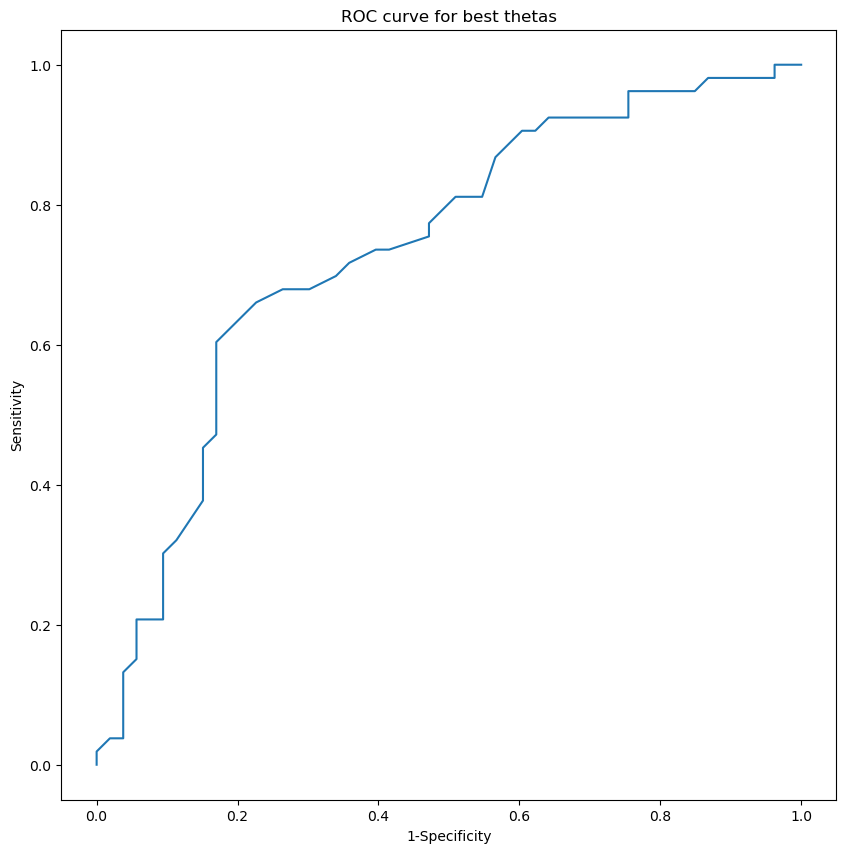

In [ ]:
# answer
thresholdRange = np.linspace(1, 0, 200)
truePositiveRate = []
trueNegativeRate = []
bestThetas = finalThetaList[np.nanargmin(testCostList)]
predictionsBest = linAlgLogRegHypothesis(testDataDiabetes, bestThetas)

for threshold in thresholdRange:
    classLabelsThisThreshold = np.ravel(np.where(predictionsBest <= threshold, 0, 1))
    truePositive = np.sum(
        classLabelsThisThreshold[np.ravel(testClassLabelsDiabetes == 1)] == 1
    )
    falsePositive = np.sum(
        classLabelsThisThreshold[np.ravel(testClassLabelsDiabetes == 0)] == 1
    )
    trueNegative = np.sum(
        classLabelsThisThreshold[np.ravel(testClassLabelsDiabetes == 0)] == 0
    )
    falseNegative = np.sum(
        classLabelsThisThreshold[np.ravel(testClassLabelsDiabetes == 1)] == 0
    )
    TPR = truePositive / (truePositive + falseNegative)
    TNR = trueNegative / (trueNegative + falsePositive)
    truePositiveRate.append(TPR)
    trueNegativeRate.append(TNR)

oneMinusSpecificity = [1 - elem for elem in trueNegativeRate]
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(oneMinusSpecificity, truePositiveRate)
ax.set_title("ROC curve for best thetas")
ax.set_xlabel("1-Specificity")
ax.set_ylabel("Sensitivity")
# ax.margins(x=0, y=0)

## What I'd like you to remember here:
* What regularisation is, and how it works (penalising large weights for parameters, thereby forcing the algorithm to focus on those that really give it a lot of _bang for its buck_ and decreasing overfitting)
* How to implement regularisation, and how the parameter $\lambda$ affects it
* How to do some basic cleaning on a dataset, and what _the idea_ of imputation is (specifically of a KNNImputer)
* How to make a ROC plot, and what exactly is depicted on it, as well as why we might want to compare something like ROC AUC between classifiers, rather than accuracy. Note also that ROC AUC also compares wholly unrealistic thresholds (we would never use a threshold where we just say that everyone is positive or negative, say), so more clever comparison metrics exist. Note also that the ROC AUC does not, in and of itself, say much about out-of-domain generalisation, which might be most important in the real world!

## Final words

Congratulations. You've implemented regularised logistic regression on a real dataset (that you cleaned up yourself) and made your own ROC curve. We'll now move on to multiclass logistic regression and then to neural networks!

## Survey
"I want a Survey, hey! Giving feedback for the very first time. I want a su-u-u-u-rvey, got some feedback, on my mi-i-i-n-d". Thanks Weird Al, [very cool](https://www.youtube.com/watch?v=notKtAgfwDA). Here you go: [clickety-click](https://docs.google.com/forms/d/e/1FAIpQLSfaeqtRTz5KMqcmxQuOI5GYWHMejjh5_yuiCNSnNblpdKb0hQ/viewform?usp=sf_link).